In [7]:
%matplotlib inline
# 便于在jupyter中显示图像，inline表示将图像嵌入到jupyter中
import torch
import random
from torch.utils import data
from d2l import torch as d2l

# 生成数据集，构造一个带有噪声的线性数据集

In [3]:
def synthetic_data(w, b, num_examples):  # @save
    """生成 y = Xw + b + 噪声。"""
    X = torch.normal(0, 1, (num_examples, len(w))) # 生成一个服从正态分布(0,1)的数据集
    y = torch.matmul(X, w) + b # 矩阵乘法
    y += torch.normal(0, 0.01, y.shape) # 添加噪声
    return X, y.reshape((-1, 1)) # 返回X和y,y的形状为(num_examples,1)

In [4]:
# 通过函数构造数据集
true_w = torch.tensor([2, -3.4]) #与X相乘的权重
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
# d2l内置了synthetic_data函数，可以直接调用

# 绘制数据集的散点图

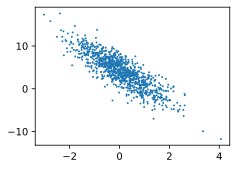

In [5]:
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1);
# detach()返回一个新的tensor，从当前计算图中分离下来的，但是仍指向原变量的存放位置

# 读取数据集


In [ ]:
# 原始方法构造
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples)) # 生成一个从0到num_examples-1的列表
    random.shuffle(indices) # 用于将一个列表中的元素打乱顺序，不会生成新的列表，只是将原列表的次序打乱
    # 随机读取小批量
    for i in range(0, num_examples, batch_size): # 从0到num_examples，每次增加batch_size
        batch_indices = torch.tensor(indices[i:min(i + batch_size, num_examples)])
        # 生成一个从i到min(i+batch_size,num_examples)的列表
        yield features[batch_indices], labels[batch_indices]
        # yield关键字用于生成器，返回一个生成器对象

In [8]:
# d2l内置函数
def load_array(data_arrays, batch_size, is_train=True):  #@save
    """构造一个PyTorch数据迭代器。"""
    dataset = data.TensorDataset(*data_arrays) # 传入的参数是一个元组，*data_arrays表示解包
    return data.DataLoader(dataset, batch_size, shuffle=is_train) # 返回一个DataLoader对象

batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [9]:
next(iter(data_iter)) # 返回一个迭代器对象,可以使用next()函数获取下一个元素,返回的是一个batch_size大小的数据


[tensor([[ 1.5735,  0.0169],
         [ 0.3610, -0.5733],
         [-0.2335,  1.1352],
         [ 0.6575, -1.1790],
         [ 0.7694, -1.6750],
         [-0.8095,  1.0847],
         [ 1.2915,  0.2037],
         [ 0.2637,  0.0499],
         [-1.2849,  0.7359],
         [-0.5693, -0.5967]]),
 tensor([[ 7.3034],
         [ 6.8584],
         [-0.1337],
         [ 9.5314],
         [11.4314],
         [-1.0970],
         [ 6.0874],
         [ 4.5604],
         [-0.8780],
         [ 5.0933]])]

#  模型函数定义

In [ ]:
# 初始化模型参数
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

# 定义模型
def linreg(X, w, b):  #@save
    """线性回归模型。"""
    return torch.matmul(X, w) + b

# 定义损失函数
def squared_loss(y_hat, y):  #@save
    """均方损失。"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2 # 返回一个张量，张量的形状与y_hat相同

# 定义优化算法
def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降。"""
    with torch.no_grad(): # 禁用梯度计算
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [10]:
# 定义模型
from torch import nn
net = nn.Sequential(nn.Linear(2, 1)) # 一个线性层,输入特征为2，输出特征为1

# 初始化模型参数
net[0].weight.data.normal_(0, 0.01) # 初始化权重
net[0].bias.data.fill_(0) # 初始化偏置

loss = nn.MSELoss() # 定义损失函数,均方损失, 计算公式为(y_hat - y)^2/2

# 定义优化算法
trainer = torch.optim.SGD(net.parameters(), lr=0.03) # 使用小批量随机梯度下降


# 训练函数

In [ ]:
lr=0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(10, features, labels):
        l = loss(net(X, w, b), y)  # l是有关小批量X和y的损失
        l.sum().backward()  # 小批量的损失对模型参数求梯度
        sgd([w, b], lr, 10)  # 使用小批量随机梯度下降迭代模型参数

        with torch.no_grad():
            train_l = loss(net(features, w, b), labels)
            print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

In [ ]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

In [11]:
# 使用d2l库训练
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y)  # l是有关小批量X和y的损失
        trainer.zero_grad()  # 梯度清零
        l.backward()  # 小批量的损失对模型参数求梯度
        trainer.step()  # 使用小批量随机梯度下降迭代模型参数
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000444
epoch 2, loss 0.000101
epoch 3, loss 0.000101
